# Photon Cross Section

## Useful costants

In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#Planck Constant(ergs)
h = 6.62606957e-27

#Planck Constant(eVs)
h_eV = 4.135667662e-15

#Boltzmann Constant(erg/K)
k = 1.3806485279e-16

#frequence_0
mu0 = 1e0/h

#Gravitional constant(cm^3/g/s)
G = 6.67408e-8

#Mass of a Hydrogen atom(g)
mH = 1.67357e-24

#Mass of a Helium atom(g)
mHe = 1.67357e-24*4.0026022/1.00794

nH = 1e5
nHe = 1e4

xe = 0


#Initial conditions
T = 1.6e2 #K
J21 = 0.1

In [2]:
from Spectrum_to_Ionization import Spec #Guangshuai's data
import Spectrum_to_Ionization as spi

## Calculating the cross sections of HI and HeI

In [3]:
class atom:
    def __init__(self, name, Eth, Emax, E0, sigma0, ya, P, yw, y0, y1):
        self.name = name
        self.Eth, self.Emax, self.E0 = Eth, Emax, E0
        self.sigma0, self.P = sigma0, P
        self.ya, self.yw, self.y0, self.y1 = ya, yw, y0, y1
        if (name == 'H'):
            self.aa, self.bb, self.cc = 0.3908, 0.4092, 1.7592
        elif (name == 'He'):
            self.aa, self.bb, self.cc = 0.0554, 0.4614, 1.666
        else:
            self.aa, self.bb, self.cc = 0, 0, 0

    def cross(self, E):
        x = E/self.E0-self.y0
        y = np.sqrt(x**2+self.y1**2)
        D = (x-1)**2+self.yw**2
        B = np.power(y, 0.5*self.P-5.5)
        C = np.power(1+np.sqrt(y/self.ya),-self.P)
        return(D*B*C*self.sigma0*1e-18)

    def draw(self):
        E = np.linspace(self.Eth, self.Emax, 10000)
        sigma = self.cross(E)
        plt.xscale('log')
        plt.yscale('log')
        plt.plot(E, sigma, label=self.name)
        plt.xlabel("E(eV)",fontsize=13)
        plt.ylabel("$\sigma$(cm$^2$)",fontsize=13)
        plt.legend()

    def min(self):
        return self.Eth

    def max(self):
        return self.Emax

    def getabc(self):
        return self.aa, self.bb, self.cc

In [37]:
def main():
    H = atom('H', 1.360E+1, 5.000E+04, 4.298E-01, 5.475E+04, 3.288E+01, 2.963E+00, 0.000E+00, 0.000E+00, 0.000E+00)
    He = atom('He', 2.459E+1, 5.000E+04, 1.361E+01, 9.492E+02, 1.469E+00, 3.188E+00, 2.039E+00, 4.434E-01, 2.136E+00)
    C = atom('C',1.126E+01, 2.910E+02, 2.144E+00, 5.027E+02, 6.216E+01, 5.101E+00, 9.157E-02, 1.133E+00, 1.607E+00)
    O = atom('O',1.362E+01, 5.380E+02, 1.240E+00, 1.745E+03, 3.784E+00, 1.764E+01, 7.589E-02, 8.698E+00, 1.271E-01)
    N = atom('N',1.453E+01, 4.048E+02, 4.034E+00, 8.235E+02, 8.033E+01, 3.928E+00, 9.097E-02, 8.598E-01, 2.325E+00)
    Mg = atom('Mg',7.646E+00, 5.490E+01, 1.197E+01, 1.372E+08, 2.228E-01, 1.574E+01, 2.805E-01, 0.000E+00, 0.000E+00)
    H.draw()
    #He.draw()
    #C.draw()
    #O.draw()
    #plt.show()
    print(O.cross(500)/H.cross(500))
    print(C.cross(500)/H.cross(500))
    print(O.cross(1000)/H.cross(1000))
    print(C.cross(1000)/H.cross(1000))
    print(N.cross(1000)/H.cross(1000))
    print(Mg.cross(1000)/H.cross(1000)) #Ratios
    print(H.cross(1000)*2e22)

302.0176806388171
103.06672815494315
411.3498814055944
154.6646755115795
282.8722370574143
7.36010384707904
0.22817346622219448


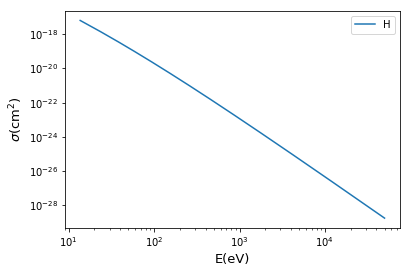

In [38]:
main()

In [6]:
H = atom('H', 1.360E+01, 5.000E+04, 4.298E-01, 5.475E+04, 3.288E+01, 2.963E+00, 0.000E+00, 0.000E+00, 0.000E+00)
He = atom('He', 2.459E+01, 5.000E+04, 1.361E+01, 9.492E+02, 1.469E+00, 3.188E+00, 2.039E+00, 4.434E-01, 2.136E+00)

## Calculating the X-rays ionization rates of HI and HeII
> Latif+ 2015

- The primary ionization rate

$$
\zeta_p^i=\frac{4\pi}{h}\int_{E_{min}}^{E_{max}}\frac{J(E)}{E}e^{-\tau(E)}\sigma^i(E)\text{d}E\\
J(E)=J_{X,21}\left( \frac{E}{1\text{keV}}\right) ^{-1.5}\times10^{-21}\text{ erg cm}^{−2}\text{ s}^{-1}\text{ Hz}^{-1} \text{ sr}^{-1}
$$

In [7]:
# Flux
def F_E(E): #E in eV, F_E in s^-1cm^-2
    return(4*np.pi/h*1e-21*np.power(E/1000.0,-1.5))

# Primary Ionization

def Ion_p(H, He, A, spec = None, nH = 1e5, nHe = 1e4):
    if spec == None:
        val1, err1 = quad(lambda epsilon:F_E(epsilon)/epsilon*np.exp(-Tau(epsilon, H, He, nH, nHe))*A.cross(epsilon), 2000, 10000)
        return(val1)
    y = np.array([])
    for i in range(len(spec.E_eV)):
        y = np.append(y, spec.Fnu_abs[i]/h/spec.E_eV[i]*np.exp(-Tau(spec.E_eV[i], H, He, nH, nHe))*A.cross(spec.E_eV[i]))
    return(inte(spec.E_eV, y))

- Optical depth $\tau$ is determined by the size of the cloud as well as the abundance of each species

$$
\tau(E)=\sum_{i=\mathrm H,\mathrm He}N_i\sigma^i=\frac{\lambda_J}{2}\sum_{i=\mathrm H,\mathrm He}n_i\sigma^i
$$

- To estimate the size we take Jeans length

$$
\lambda_J=\sqrt{\frac{\pi kT}{G\rho \mu m_p}}
$$

where the mean molecular mass
$$
\mu=\frac{1.00794n_H+4.0026022n_{He}}{n_H+n_{He}}
$$

In [8]:
# Jeans Length (Consider only H/He)
def Jeans(nH, nHe):
    rhogas = nH*mH+nHe*mHe
    mu = (4.0026022*nHe+1.00794*nH)/(nH+nHe)
    jeans_length = np.sqrt(np.pi*k*T/rhogas/mH/G/mu)
    return(jeans_length)

# Optical Depth
def Tau(E, H, He, nH = 1e5, nHe = 1e4):
    lambda_j = Jeans(nH, nHe)
    NH, NHe = nH*lambda_j, nHe*lambda_j
    tau = H.cross(E)*NH + He.cross(E)*NHe
    return(tau/2.0)

# Column Density
def Col(nH, nHe):
    lambda_j = Jeans(nH, nHe)
    col = (nH+nHe)*lambda_j
    return(col/2.0)

- $\sigma^i$ comes from Verner $\&$ Ferland (1996)

- $\langle\phi^j\rangle​$ is much more complex. For $E>100​$eV and H, He mixture

$$
\phi^H(E,x_e)=\left( \frac{E}{13.6\text{eV}}-1\right)0.3908(1-x_e^{0.4092})^{1.7592}\\
\phi^{He}(E,x_e)=\left( \frac{E}{24.6\text{eV}}-1\right)0.0554(1-x_e^{0.4614})^{1.666} 
$$

where $x_e​$ is the electron fraction
$$
\langle\phi^i\rangle=\frac{\int J(E)\phi^i(E,x_e)\text{d}E}{\int J(E)\text{d}E}
$$

To simpily calculate this integration (in the certain energy range from 2 keV to 10 keV), the KROME package takes an approximation
```fortran
phiH = .3908d0*(1d0-xe**.4092)**1.7592 * 327.832286034056d0
phiHe = .0554d0*(1d0-xe**.4614)**1.666 * 180.793458763612d0
```
that is
$$
\langle\phi^H\rangle=\frac{\int J(E)\phi^i(E,x_e)\text{d}E}{\int J(E)\text{d}E}\approx\left( \frac{E_{eff}}{13.6\text{eV}}-1\right)0.3908(1-x_e^{0.4092})^{1.7592}\\
\langle\phi^{He}\rangle\approx\left( \frac{E_{eff}}{24.6\text{eV}}-1\right)0.0554(1-x_e^{0.4614})^{1.666} 
$$
where $E_{eff}\approx$ 4.472 keV

In [9]:
def phi(E, A):
    aa, bb, cc = A.getabc()
    ph = (E/A.min()-1)*aa*np.power(1-np.power(xe, bb), cc)
    return ph

def phi_bar(A, spec = None):
    if spec == None:
        J_Phi, err1 = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*phi(epsilon, A), 2000, 10000)
        J, err2 = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5), 2000, 10000)
        return(J_Phi/J)
    J_Phi = np.array([])
    J = np.array([])
    for i in range(len(spec.E_eV)):
        J_Phi = np.append(J_Phi, spec.Fnu_abs[i]*phi(E_eV[i], A))
        J = np.append(J_Phi, spec.Fnu_abs[i])
    return(inte(spec.E_eV, J_Phi)/inte(spec.E_eV, J))

def phi_b(A):
    aa, bb, cc = A.getabc()
    if A.name == 'H':
        return 327.832286034056e0*aa*np.power(1-np.power(xe, bb), cc)
    elif A.name == 'He':
        return 180.793458763612e0*aa*np.power(1-np.power(xe, bb), cc)
    else:
        return 0

def Ion_x(n1, n2, H, He, A, B, spec = None): #the method offered in Latif 2015
    Ip = Ion_p(H, He, A, spec)
    zeta_2 = (Ip + n2/n1*Ion_p(H, He, B, spec))*phi_bar(A)
    return(Ip + zeta_2)

def Ion_xx(n1, n2, H, He, A, B, spec = None): #what krome is actually using(simplified phi_b)
    Ip = Ion_p(H, He, A, spec)
    zeta_2 = (Ip + n2/n1*Ion_p(H, He, B, spec))*phi_b(A)
    return(Ip + zeta_2)

def Ion_xxx(n1, n2, H, He, A, B, spec = None):
    Ip = Ion_p(H, He, A, spec)
    I21,err1 = quad(lambda epsilon:F_E(epsilon)*np.exp(-Tau(epsilon, H, He))/epsilon*B.cross(epsilon)*phi(epsilon,A), 2000, 10000)
    I22,err2 = quad(lambda epsilon:F_E(epsilon)*np.exp(-Tau(epsilon, H, He))/epsilon*A.cross(epsilon)*phi(epsilon,A), 2000, 10000)
    print(I22/Ion_p(H, He, A, spec)/phi_bar(A))
    print(I21/Ion_p(H, He, B, spec)/phi_bar(A))
    print()
    return(Ip+n2/n1*I21+I22)

- The total X-ray ionization rate for certain species $i$

$$
\zeta_x^i=\zeta_p^i+\sum_{j=H,He}\frac{n_j}{n_i}\zeta_p^j\langle\phi^j\rangle
$$

where $n_j​$ is the number density

In [10]:
def test(H, He, spec = None):
    print(H.name, np.log10(Ion_p(H, He, H, spec)), np.log10(Ion_x(nH, nHe, H, He, H, He, spec)))
    print(He.name, np.log10(Ion_p(H, He, He, spec)), np.log10(Ion_x(nHe, nH, H, He, He, H, spec)))
    print()
    #print(Ion_x(nH, nHe, H, He, H, He, spec)/Ion_p(H, He, H, spec), np.log10(Ion_x(nH, nHe, H, He, H, He, spec)))
    #print(Ion_x(nHe, nH, H, He, He, H, spec)/Ion_p(H, He, H, spec), np.log10(Ion_x(nHe, nH, H, He, He, H, spec)))
    #print()
    #print(Ion_xx(nH, nHe, H, He, H, He), np.log10(Ion_xx(nH, nHe, H, He, H, He)))
    #print(Ion_xx(nHe, nH, H, He, He, H), np.log10(Ion_xx(nHe, nH, H, He, He, H)))
    #print()
    #print(Ion_xxx(nH, nHe, H, He, H, He), np.log10(Ion_xxx(nH, nHe, H, He, H, He)))
    #print(Ion_xxx(nHe, nH, H, He, He, H), np.log10(Ion_xxx(nHe, nH, H, He, He, H)))

## Draw the flux-energy diagram

In [11]:
def draw_flux(H, He):
    E = np.linspace(100, 5.000E+06, 100000)
    T = np.exp(-Tau(E, H, He))
    J0 = J21*1e-21*np.power(E/1000.0,-1.5)
    Jx = J0*T

    fx = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*4*np.pi/((h_eV)), 2000, 1000000)[0]
    fy = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*np.exp(-Tau(epsilon, H, He))*4*np.pi/((h_eV)), 2000, 1000000)[0]
    print(fx, fy)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.loglog(E, J0, label='$J_0$')
    plt.loglog(E, Jx, label='$J_H$')
    plt.xlabel("E(eV)",fontsize=13)
    plt.ylabel("$J$(erg/cm2/s/Hz)",fontsize=13)
    plt.xlim([1e2,1e6])
    plt.ylim([1e-30,1e-15])
    #plt.legend()
    plt.show()
    J1 = J0*T*H.cross(E)
    J2 = J0*T*He.cross(E)
    #plt.ylim([5e-6,1e-3])
    #plt.plot(E, J1, label='$J_H$')
    #plt.plot(E, J2, label='$J_{He}$')
    plt.loglog(E*1.6021773e-12/h, Jx*4*np.pi*E/(4.135667662e-15), label=r'$\nu F_{\nu}$')
    plt.ylim([1e-20,1e0])
    plt.xlabel(r"$\nu$(Hz)",fontsize=13)
    plt.ylabel(r"$\nu F_{\nu}$(erg cm$^{-2}$ s$^{-1}$)",fontsize=13)
    #plt.legend()
    return()

## Calculate the real ionization rate using Guangshuai's data

In [12]:
def inte(x, y, lower = -np.inf, upper = np.inf): #integration with bounds
    s = 0
    ran = np.array([], dtype='int64')
    for i in range(len(x)):
        if x[i] > lower:
            ran = np.append(ran, int(i))
        if x[i] > upper:
            break
    x, y = np.take(x, ran), np.take(y, ran)
    return(np.trapz(y,x)) #integration

### Comparison

- $F_\nu-\nu$ (eV)

In [13]:
def draw_Fnu(i, col1, col2, col3, absorb = True):
    plt.loglog(i.E_eV, i.Fnu, label = i.title(), lw = 0.4, color = col1)
    plt.xlabel(r'$E$(eV)')
    plt.ylabel(r'$F($erg s$^{-1}$ cm $^{-2}$ Hz $^{-1}$)')

    plt.xlim([1e-1,1e6])
    if absorb:
        plt.loglog(i.E_eV, i.Fnu_abs, '--', label = i.title() + ' (absorption)', lw = 1, color = col2)
    plt.loglog(i.E_eV, i.Fnu_abs, '.', label = i.title() + ' (absorption*)', lw = 1, color = col3)
    plt.loglog(i.E_eV, i.Fnu_abs*np.exp(-Tau(i.E_eV, H, He)), '-.', label = i.title() + ' (absorption*)', lw = 1, color = col3)
    #plt.legend()
    
    plt.xlim([1e2,1e6])
    plt.ylim([1e-30,(i.Fnu).max()*10])
    
def draw_Fnu_model():
    E = np.linspace(100, 5.000E+06, 100000)
    ext = np.exp(-Tau(E, H, He))
    F0 = 4*np.pi*J21*1e-21*np.power(E/1000.0,-1.5)
    Fx = F0*ext
    
    plt.loglog(E, F0, label = r'power law', color = '#006284')
    plt.loglog(E, Fx, '-.', label = r'power law (absorption*)', color = '#81C7D4')
    plt.xlabel("E(eV)", fontsize=13)
    plt.ylabel("$F$(erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)", fontsize=13)

- $\nu F_\nu-\nu$ (Hz)

In [14]:
def draw_nuF(i, col1, col2):
    plt.loglog(i.nu, i.Fnu*i.nu, label = i.title(), lw = 0.4, color = col1)
    plt.loglog(i.nu, i.Fnu_abs*i.nu, '-.', label = i.title(), lw = 0.8, color = col2)
    plt.ylim([1e-8,(i.Fnu*i.nu).max()*10])
    plt.xlim([1e13,1e21])
    #plt.legend()
    
def draw_nuF_model():
    E = np.linspace(100, 5.000E+06, 100000)
    ext = np.exp(-Tau(E, H, He))
    F0 = 4*np.pi*J21*1e-21*np.power(E/1000.0,-1.5)
    Fx = F0*ext
    
    plt.loglog(E*1.6021773e-12/h, Fx*E/(4.135667662e-15), label='power law', color = '#006284')
    plt.xlabel(r"$\nu$(Hz)",fontsize=13)
    plt.ylabel(r"$\nu F_{\nu}$(erg cm$^{-2}$ s$^{-1}$)", fontsize=13)

- $\nu L_\nu-\nu$ (Hz)

In [15]:
def draw_nuL(i, col1, col2):
    plt.loglog(i.nu, i.Lnu*i.nu, lw = 0.4, color = col1)
    plt.loglog(i.nu, i.Fnu_abs*i.nu*4*np.pi*i.distance_cm**2, '-.', label = i.title(), lw = 0.8, color = col2)
    plt.ylim([1e40,(i.Lnu*i.nu).max()*10])
    plt.xlim([1e13,1e21])
    #plt.legend()
    
def draw_nuL_model():
    E = np.linspace(100, 5.000E+06, 100000)
    ext = np.exp(-Tau(E, H, He))
    F0 = 4*np.pi*J21*1e-21*np.power(E/1000.0,-1.5)
    Fx = F0*ext
    
    plt.loglog(E*1.6021773e-12/h, Fx*E/(4.135667662e-15)*4*np.pi*(8*3.08567758e21)**2,  color = '#006284')
    plt.xlabel(r"$\nu$(Hz)",fontsize=13)
    plt.ylabel(r"$\nu L_{\nu}$(erg s$^{-1}$)", fontsize=13)

- Read parameters, pick out certain spectra

In [16]:
def compare(distance, dic):
    ty = '.txt'
    path = '/Users/chang/X-ray-chemistry/Calc_ionization_rate/spectrum data/spectrum/'
    ab, ab_UV = spi.read_abs()
    data_list = spi.readfile(path, ty, distance, ab, ab_UV)
    
    keys = np.array([], dtype = 'int64')
    for i in range(len(data_list)):            
        if data_list[i].info() == dic:
            keys = np.append(int(i), keys)
    if len(keys) == 0:
        print('No such data:')
        print(dic)
        return
    Dat = np.take(data_list, keys).ravel().copy()
    return(Dat)

In [17]:
def Eh(ma, mi, alpha):
    xx = (1-alpha)/(2-alpha)
    yy = (ma**(2-alpha)-mi**(2-alpha))/(ma**(1-alpha)-mi**(1-alpha))
    return(xx*yy)
Eh(100, 0.2, 1.7)

2.57750323464073